# RESULTS
Here I report the results of the training of the model for the weakly interacting regime.

In [28]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py

from mpl_toolkits.axes_grid1 import make_axes_locatable

from pathlib import Path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
prms = {'L' : 20,                # length of spin chain
        'sites' : [0, 1],        # sites of the subsystem S spins
        'omega' : 1,             # Rabi frequency
        'beta' : [1],            # inverse temperature
        # interaction of subsystem's S spins
        'potential' : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.5],       
        'potential_' : None,     # interaction of bath spins, if None same as potential
        'T' : 10,                # total time for the evolution
        'dt' : 0.01,             # interval every which save the data
        'cutoff' : 1e-5,         # cutoff for TEBD algorithm
        'im_cutoff' : 1e-10,      # cutoff for TEBD algorithm, img t-e
        'tolerance' : 1e-3,      # Trotter tolerance for TEBD algorithm
        'verbose' : True,        # verbosity of the script
        'num_traj' : 30,         # how many trajectories to do
        # file to save the data
        'fname' : './data/data_tebd.hdf5'
        }

ml_params = {'model_dir': './data/trained_model', # folder where the metadata of the training are stored
             'validation_split' : 0.8,
             'batch_size': 256,
             #'batches_per_epoch': 256,
             'n_epochs': 30,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt' : 0.01
                 },
             }

In [3]:
def print_comparison(data_tebd, data_ml, T, dt, ylim):
    t = np.arange(0, T, dt)[:-1]
        
    rows= 5
    columns = 3
    
    names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, [data_tebd[k][(columns-1)*i+j] for k in range(len(t))], label='Simulation', color='k')
            axs[i, j].plot(t, [data_ml[k][(columns-1)*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            axs[i, j].set_title(names[(columns-1)*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

## Does it generalize? 
### L = 20

In [4]:
from ml.classes import MLLP
from ml.utils import calculate_error

In [5]:
# for each combinations of potential and training T

T_max = 20
beta = 1
fname = './data/data_test_W.hdf5'

training_times = [3,4,5,6,7,8,9,10]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

errors = []

for T_train in training_times:
    err = []
    for vv in potential:
        # import TEBD data
        gname = 'cohVec_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File(fname, 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(T_train).zfill(2)

        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=T_max, dt=prms['dt']))
    errors.append(err)

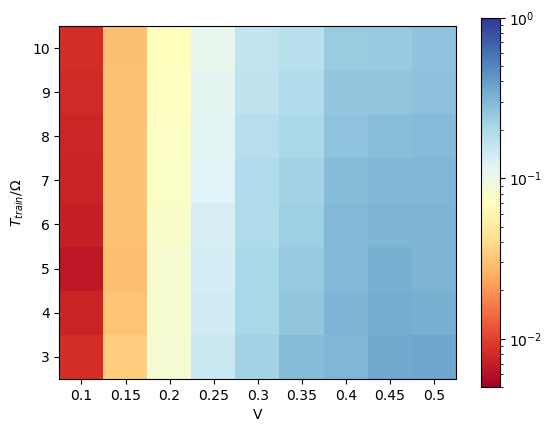

In [7]:
fig, ax = plt.subplots()

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.005, vmax=1))

my_x_ticks = potential
my_y_ticks = training_times
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$T_{train}/\Omega$')

fig.colorbar(im, ax=ax)

plt.show()
#fig.savefig('../pictures/extrapolation_W.pdf', dpi=150)

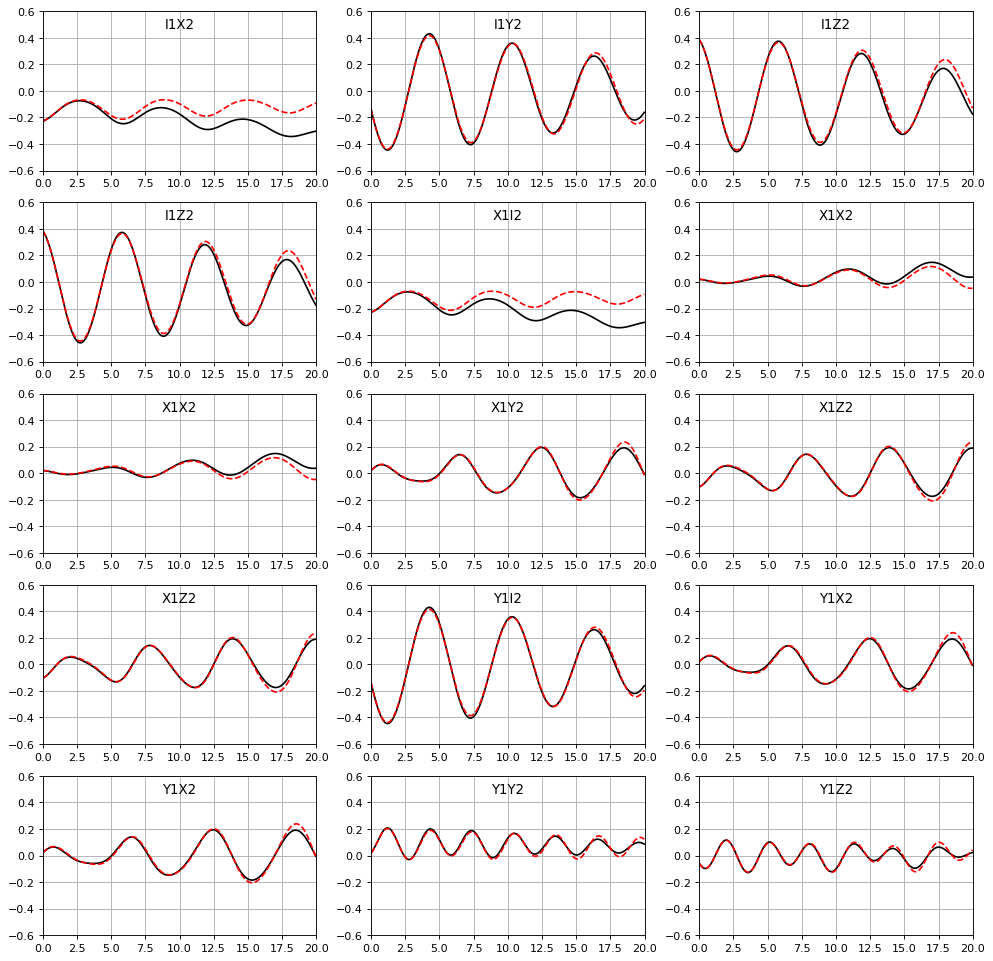

In [52]:
T_train = 10
vv = 0.2
# import TEBD data
gname = 'cohVec_L_' + str(prms['L']) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File(fname, 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(prms['L']) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

print_comparison(data_tebd, ml_dyn, T_max, dt=0.01, ylim=0.6)

## Comparison L = 20, 40, 60

In [24]:
# for each combinations of potential and L I calculate the error

T_max = 20
T_train = 4
beta = 1

L = [20, 40, 60]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

errors = []

for l in L:
    err = []
    for vv in potential:
        # import TEBD data
        gname = 'cohVec_L_' + str(l) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        #print(gname)
        with h5py.File('./data/data_test_W.hdf5', 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(l) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(T_train).zfill(2)

        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=T_max, dt=prms['dt']))
    errors.append(err)

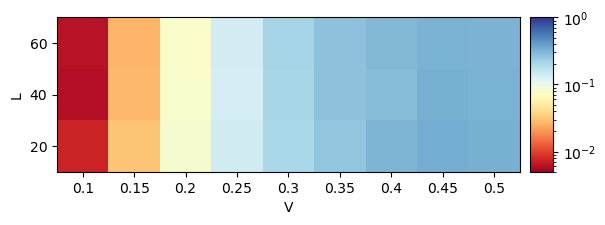

In [35]:
fig, ax = plt.subplots()

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.005, vmax=1))

my_x_ticks = potential
my_y_ticks = L
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'L')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/length_dependance_W.pdf', dpi=150)

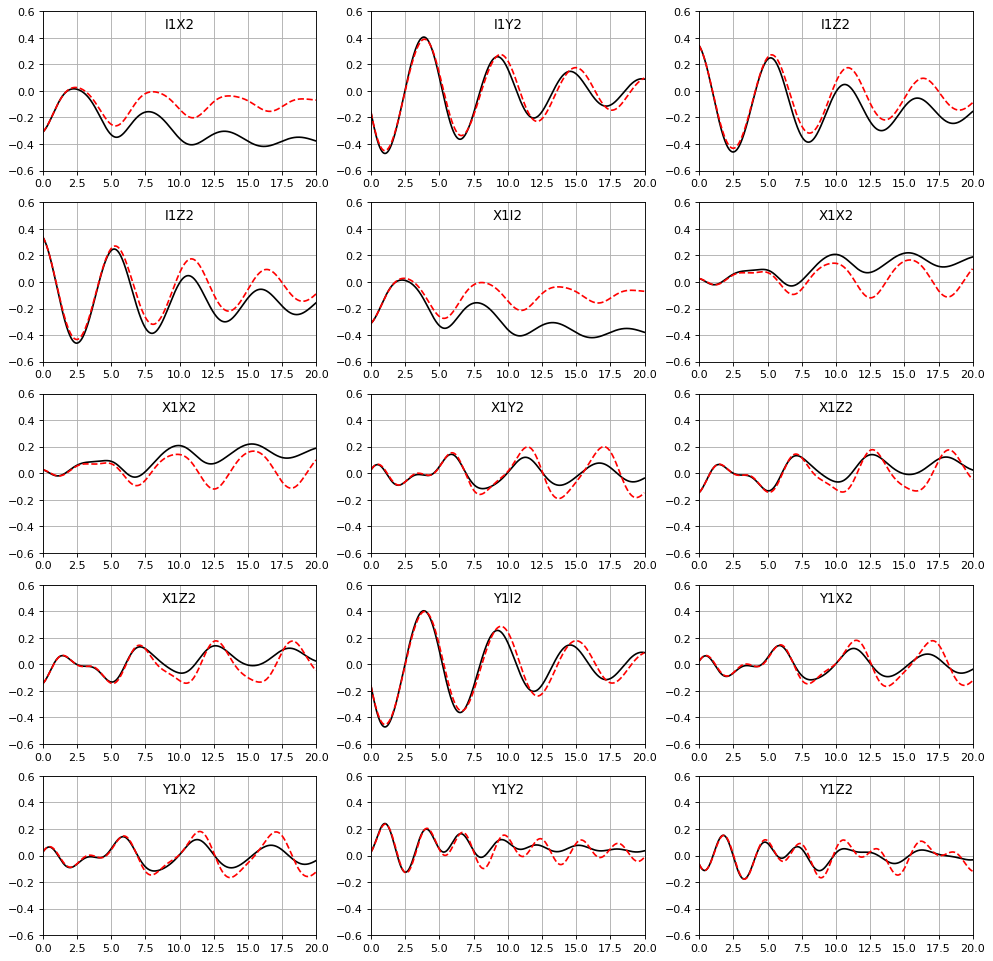

In [9]:
T_train = 4
vv = 0.5
L = 60
# import TEBD data
gname = 'cohVec_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File('./data/data_test_W.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

print_comparison(data_tebd, ml_dyn, T_max, dt=0.01, ylim=0.6)

## Thermalization

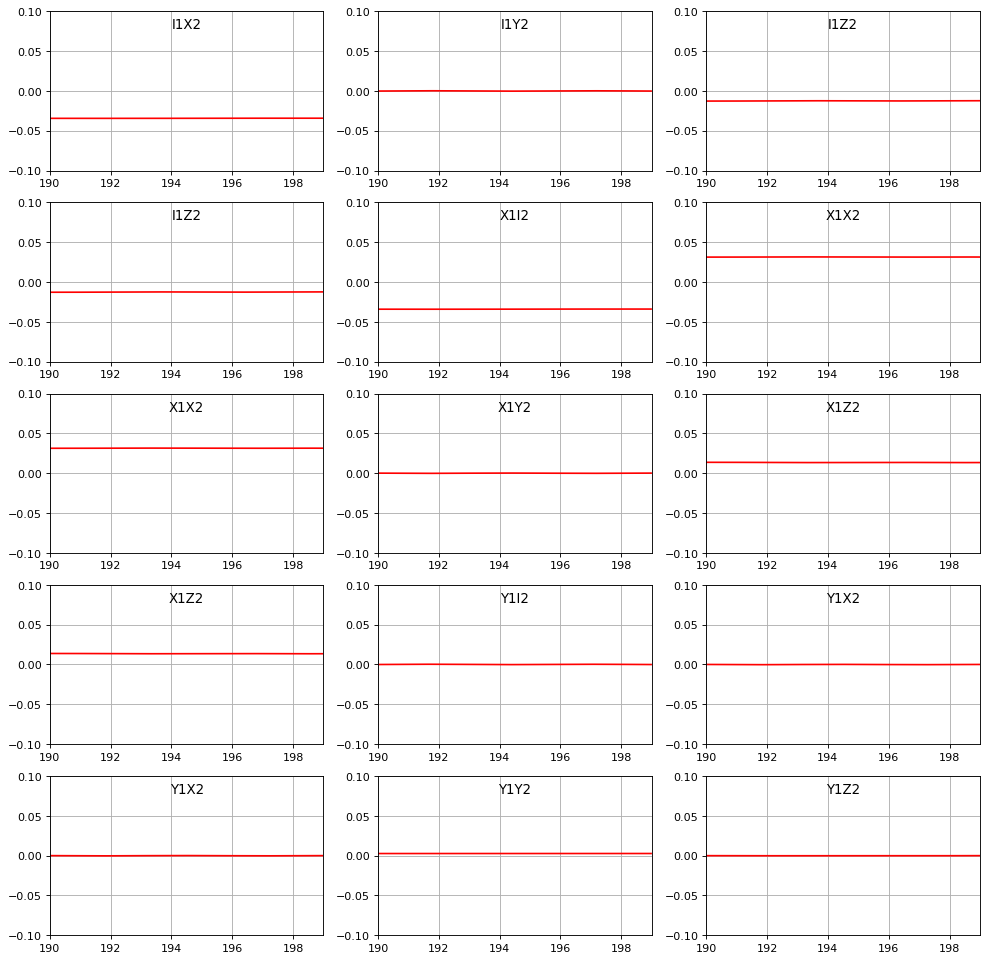

In [21]:
T_train = 4
T_max = 199
vv = 0.5
L = 60

# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

rows= 5
columns = 3
names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
plt.setp(axs, xlim=(190,T_max), ylim=(-0.1, 0.1))
t = np.arange(0, T_max, prms['dt'])[:-1]

for i in range(rows):
    for j in range(columns):
        #if i == rows-1 & j == columns-1:
        #    continue
        axs[i, j].plot(t[9000:], [ml_dyn[k][(columns-1)*i+j] for k in range(9000,len(t))], label='ml', color='r')
        axs[i, j].grid()
        axs[i, j].set_title(names[(columns-1)*i+j], x=0.5, y=0.85)
axs[4, 2].grid()
#plt.legend()
plt.grid()

fig = plt.gcf()
plt.show()

In [22]:
np.sort(model.MLP.gap())

array([-0.08026331, -0.07861106, -0.07797916, -0.07754012, -0.06134144,
       -0.05916966, -0.05568954, -0.05234236, -0.04602794, -0.04415563,
       -0.042765  , -0.03782689, -0.02536998, -0.01821567, -0.01702007,
        0.        ], dtype=float32)